<a href="https://colab.research.google.com/github/each-yi/solar-pr-analysis/blob/main/dna_project_code_0727.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


필요한 라이브러리 설치

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 업로드 할 파일들은 이 셀에 코드 작성하기
dataset = pd.read_excel("/content/drive/MyDrive/df.xlsx")
df_control = pd.read_excel("/content/drive/MyDrive/제주태양광출력제한_워크시트.xlsx")

# 1. dataset 정리하기

**[데이터셋 설명]**\
df: 18개의 발전소의 경사면 일사량, 인버터 별 발전량, 모듈 및 외기 온도 자료와 더불어 기상청에서 추가적으로 강수량, 풍속, 습도 경사 고도 등의 자료를 추가함.\
df_control: 출력제한 워크시트에 있던 내역들, 해당 시간들은 고장은 아니지만 정상 PR 패턴을 파악하기 위해서는 삭제가 필요함.

In [ ]:
df = dataset.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176825 entries, 0 to 176824
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Datatime     176825 non-null  object 
 1   발전소명         176825 non-null  object 
 2   용량(MW)       176825 non-null  float64
 3   정격출력(kWh)    176825 non-null  int64  
 4   모듈용량(Wp)     176825 non-null  int64  
 5   모듈수량         176825 non-null  int64  
 6   용량대비 평균      176825 non-null  float64
 7   경사면일사량       176825 non-null  object 
 8   INV0001_발전량  176825 non-null  object 
 9   INV0002_발전량  176825 non-null  object 
 10  발전량합계        162842 non-null  object 
 11  습도(%)        176733 non-null  float64
 12  강수량(mm)      176825 non-null  float64
 13  풍속(m/s)      176669 non-null  float64
 14  태양고도         176825 non-null  float64
 15  외기온도(°C)     176059 non-null  float64
 16  모듈온도(°C)     161085 non-null  float64
dtypes: float64(8), int64(3), object(6)
memory usage: 22.9+ MB


Datatime은 시간 정보가 인덱스에 있어야 해서 타입을 바꿔줘야 하는 것 같음.\
df.info()를 통해 확인한 결과 숫자형이 아닌 문자형으로 표시 되는 몇 가지가 있음\
엑셀에 숫자지만 문자로 인식한 열들을 정리하기 위한 코드\
[경사면일사량, INV0001_발전량, INV0002_발전량, 발전량합계]


In [ ]:
df['Datatime'] = pd.to_datetime(df['Datatime'])
df["경사면일사량"] = pd.to_numeric(df["경사면일사량"], errors="coerce")
df['INV0001_발전량'] = pd.to_numeric(df['INV0001_발전량'], errors='coerce')
df['INV0002_발전량'] = pd.to_numeric(df['INV0002_발전량'], errors='coerce')
# erroes = 'coerce' / 숫자로 변환할 수 없으면 Nan 값으로 처리

우선 쓸 일 없는 열들은 실행 시간을 고려해 제외하고 생각하기\
일단 제외 시킬 열 목록\
[용량대비 평균, 습도, 풍속, "외기온도(°C)","태양고도", ]\

인덱스 정리하기

In [ ]:
df = df[['Datatime', "발전소명", "용량(MW)", "정격출력(kWh)", "모듈용량(Wp)", "모듈수량", "경사면일사량", "INV0001_발전량", "INV0002_발전량", "발전량합계", "강수량(mm)", '외기온도(°C)', "모듈온도(°C)",  ]]

In [ ]:
df.describe()

,Datatime,용량(MW),정격출력(kWh),모듈용량(Wp),모듈수량,경사면일사량,INV0001_발전량,INV0002_발전량,강수량(mm),외기온도(°C),모듈온도(°C)
count,176825,176825.000000,176825.000000,176825.000000,176825.000000,176059.000000,1.748870e+05,95149.000000,176825.000000,176059.000000,161085.000000
mean,2024-04-16 18:57:36.895800832,0.783440,610.674396,385.139177,2036.088279,276.890377,1.321884e+05,103970.686071,0.258937,68.260668,96.378554
min,2023-03-01 06:00:00,0.428220,500.000000,375.000000,1098.000000,0.000000,-7.232981e+06,-116962.000000,0.000000,-7.055000,-14.726667
25%,2023-09-07 14:00:00,0.659100,500.000000,375.000000,1690.000000,47.084040,1.800000e+04,8000.000000,0.000000,10.286667,14.395000
50%,2024-05-13 14:00:00,0.803250,500.000000,390.000000,2142.000000,181.400000,7.948500e+04,57812.000000,0.000000,18.555000,24.435000
75%,2024-11-21 17:00:00,0.938250,750.000000,390.000000,2466.000000,464.168079,2.160575e+05,176316.000000,0.000000,25.335000,34.929630
max,2025-04-30 18:00:00,0.999000,750.000000,390.000000,2664.000000,1871.350000,7.860000e+05,486039.000000,55.200000,6553.405000,6553.416667
std,NaN,0.168805,124.176746,7.020329,445.129881,268.380201,1.408317e+05,113744.928537,1.765342,552.157499,618.602525


# 2. 분석 대상 제외 조건 설정
**전처리 개념과는 별개로 이상 여부를 판단하기에 애매한 데이터들은 제외 시키는
것이 FP를 줄여줄 수 있음.**



> 2-1) 불필요한 시간대 제외하기 위한 시각화 코드



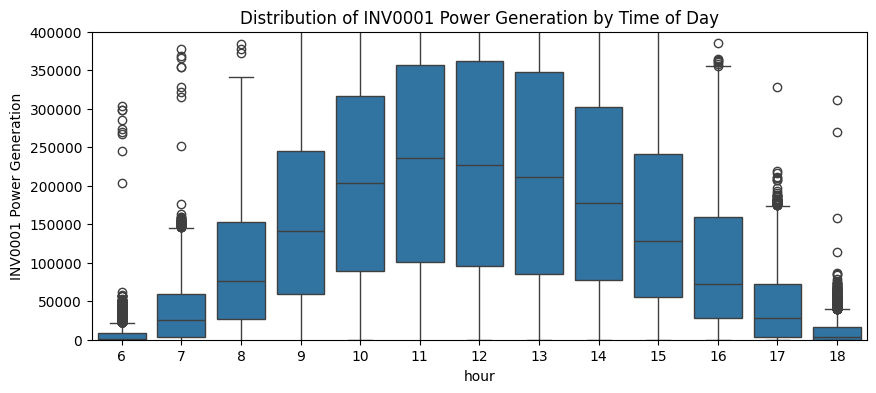

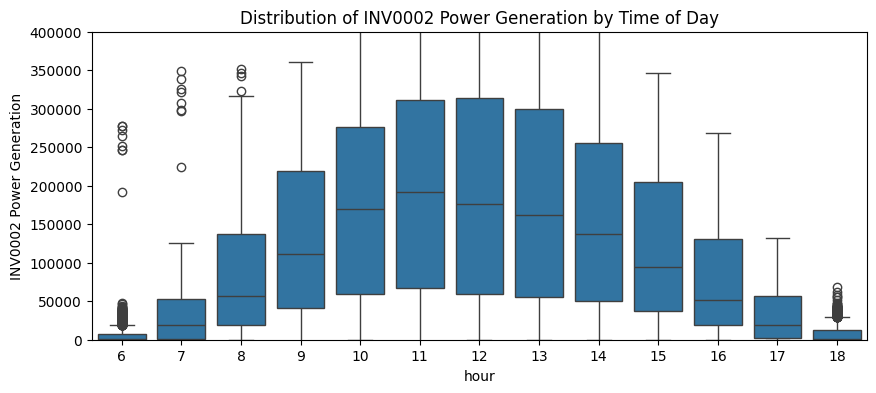

In [ ]:
# 1) 특정 시간대로 좁히기 위한 시각화 코드
df['hour'] = pd.to_datetime(df['Datatime']).dt.hour

# INV0001
plt.figure(figsize=(10, 4))
sns.boxplot(x='hour', y='INV0001_발전량', data=df)
plt.ylim(0, 400000)
plt.title("Distribution of INV0001 Power Generation by Time of Day")
plt.ylabel("INV0001 Power Generation")
plt.show()

# INV0002
plt.figure(figsize=(10, 4))
sns.boxplot(x='hour', y='INV0002_발전량', data=df)
plt.ylim(0, 400000)  # 필요 시 조정
plt.title("Distribution of INV0002 Power Generation by Time of Day")
plt.ylabel("INV0002 Power Generation")
plt.show()

In [ ]:
# IQR 기반 이상치 탐지 함수
def count_outliers(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return ((group < lower_bound) | (group > upper_bound)).sum()

# 시간대별 이상치 개수 계산
df['hour'] = pd.to_datetime(df['Datatime']).dt.hour
outlier_counts_1 = df.groupby('hour')['INV0001_발전량'].apply(count_outliers)
outlier_counts_2 = df.groupby('hour')['INV0002_발전량'].apply(count_outliers)

# 두 시리즈를 하나의 DataFrame으로 병합
outlier_df = pd.concat(
    [outlier_counts_1.rename('INV0001 이상치 수'),
     outlier_counts_2.rename('INV0002 이상치 수')],
    axis=1
)

print(outlier_df)

      INV0001 이상치 수  INV0002 이상치 수
hour                              
6              1101            610
7                51              8
8                 3              4
9                 0              0
10                0              0
11                0              0
12                2              0
13                1              0
14                0              0
15                2              0
16                7              0
17               52              0
18              410            246


시간에 따른 발전량 합계를 시각화 한 결과 6-7시, 17-18시에는 이상치가 많은 것을 확인할 수 있다.\
각 시간대에는 13,000 ~ 14,000개의 데이터가 있다.\
따라서, 해당 시간대를 제외하고 8-16시 데이터만 사용하는 것으로 한다.

In [ ]:
df = df[df['Datatime'].dt.hour.between(8, 16)]

> 2-2) 강수량이 높아서 제외할 코드

/tmp/ipython-input-55-755502737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['강수량구간'] = pd.cut(df['강수량(mm)'], bins=bins, labels=labels, include_lowest=True)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byte

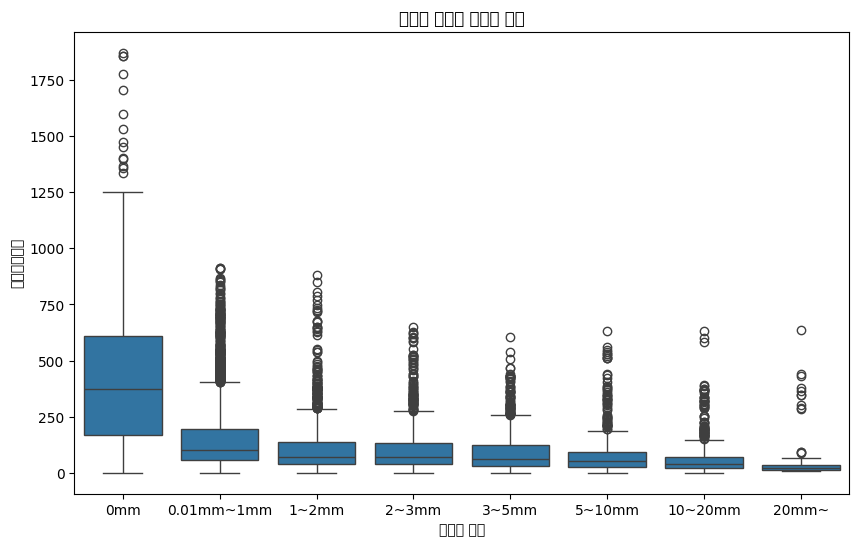

In [ ]:
bins = [0, 0.01,1, 2, 3, 5, 10, 20, 999]
labels = ['0mm','0.01mm~1mm', '1~2mm', '2~3mm', '3~5mm', '5~10mm', '10~20mm', '20mm~']
df['강수량구간'] = pd.cut(df['강수량(mm)'], bins=bins, labels=labels, include_lowest=True)

# 2. Boxplot으로 시각화 (일사량 분포)
plt.figure(figsize=(10,6))
sns.boxplot(x='강수량구간', y='경사면일사량', data=df)
plt.title('강수량 구간별 일사량 분포')
plt.xlabel('강수량 구간')
plt.ylabel('경사면일사량')
plt.show()

In [ ]:
# 1. 경사면일사량 이상치 탐지 함수 (IQR 기반)
def count_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).sum()

# 2. 구간별 통계 계산
grouped = df.groupby('강수량구간')['경사면일사량']

summary = pd.DataFrame({
    '일사량 평균': grouped.mean(),
    '일사량 이상치 개수': grouped.apply(count_outliers),
    '총 개수': grouped.count()
})

# 3. 이상치 비율도 추가 (선택)
summary['이상치 비율'] = summary['일사량 이상치 개수'] / summary['총 개수'] * 100

# 4. 결과 출력
import pandas as pd
from IPython.display import display
display(summary)


/tmp/ipython-input-56-81852410.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('강수량구간')['경사면일사량']


,일사량 평균,일사량 이상치 개수,총 개수,이상치 비율
강수량구간,,,,
0mm,399.189022,14,111614,0.012543
0.01mm~1mm,148.908351,291,4981,5.842200
1~2mm,109.336390,128,1575,8.126984
2~3mm,110.292448,81,899,9.010011
3~5mm,94.938819,70,842,8.313539
5~10mm,78.123702,58,823,7.047388
10~20mm,67.453197,71,654,10.856269
20mm~,41.800782,13,220,5.909091


시각화 및 이상치 비율 확인 결과 강수량이 0인 데이터만 두더라도 충분히 많은 양의 데이터가 확보되기 때문에 강수량이 존재하는 데이터들은 전부 제외 시켰음.

해당 강수량 자료는 발전소가 설치되어 있는 특정 위치라기보다는 제주도 전체 강수량에 관한 자료이기 때문에 부정확한 부분이 있을 수 있음. 그렇기 때문에 이상치 개수와 시각화 자료를 확인하면 0mm로만 남겨두는 것이 맞으나 부정확한 부분으로 인해 1mm이하로 제한하였음.

In [ ]:
df = df[df["강수량(mm)"] <= 1]

In [ ]:
df = df.drop(['hour', '강수량구간'], axis=1)
df.info()
# 현재까지 df의 상황을 확인하기 위한 코드

<class 'pandas.core.frame.DataFrame'>
Index: 117200 entries, 2 to 176824
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Datatime     117200 non-null  datetime64[ns]
 1   발전소명         117200 non-null  object        
 2   용량(MW)       117200 non-null  float64       
 3   정격출력(kWh)    117200 non-null  int64         
 4   모듈용량(Wp)     117200 non-null  int64         
 5   모듈수량         117200 non-null  int64         
 6   경사면일사량       116595 non-null  float64       
 7   INV0001_발전량  115783 non-null  float64       
 8   INV0002_발전량  63030 non-null   float64       
 9   발전량합계        107755 non-null  object        
 10  강수량(mm)      117200 non-null  float64       
 11  외기온도(°C)     116595 non-null  float64       
 12  모듈온도(°C)     106671 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(2)
memory usage: 12.5+ MB


> 2-3) 적설량이 높아서 제외할 코드

In [ ]:
# 추후 적설량 관련 데이터를 받으면 그때 추가하기

# 3. 이상치를 제거를 위한 전처리 ###


2번(분석 대상 제외 조건)의 과정에서는 결측치 전처리 느낌이 아니라\
1) 고장으로 이상 감지 되어도 시간대가 고장이라고 단정 짓기 애매한 시간대니까 제외시키기\
2) 이상 감지 되어도 비가 왔기 때문에 제외시키기\
3) 이상 감지 되어도 눈이 왔기 때문에 제외시키기

일반적인 경우를 다루고 있음.



---
\

하지만 이상치 제거를 위한 전처리는 실질적으로 한수원에서 데이터를 수집할 수 있는 경사면 일사량, 인버터 별 발전량, 모듈 온도, 외기 온도에 관한 자료로 진행되어야 함.\
고장이 아님에도 센서의 일시적인 오류로 인해서 결측치나 이상치가 생길 수 있는 부분임. 그것일 보정해줄 필요가 있음.



---

\
**3-1) 모듈 온도 보정**\
모듈 온도는 2가지 문제점을 가지고 있음.\
1) 빈 값이 많음\
2) 특정 값은 과도하게 온도가 높음(6000도 정도)\
위 2가지를 전처리 할 필요성이 있으며 제거는 방법이 아니라고 판단 됨

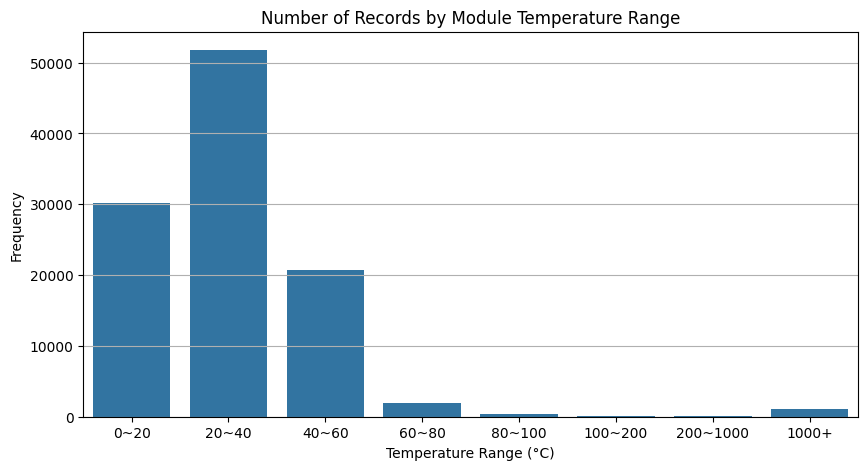

In [ ]:
bins = [0, 20, 40, 60, 80, 100, 200, 1000, 10000]
labels = ['0~20', '20~40', '40~60', '60~80', '80~100', '100~200', '200~1000', '1000+']
df['온도구간'] = pd.cut(df['모듈온도(°C)'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10, 5))
sns.countplot(x='온도구간', data=df, order=labels)
plt.title("Number of Records by Module Temperature Range")
plt.xlabel("Temperature Range (°C)")
plt.ylabel("Frequency")
plt.grid(True, axis='y')
plt.show()

In [ ]:
df.loc[df['모듈온도(°C)'] > 60, '모듈온도(°C)'] = np.nan
df['모듈온도(°C)'] = df['모듈온도(°C)'].fillna(method='ffill')

/tmp/ipython-input-61-1660177329.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['모듈온도(°C)'] = df['모듈온도(°C)'].fillna(method='ffill')


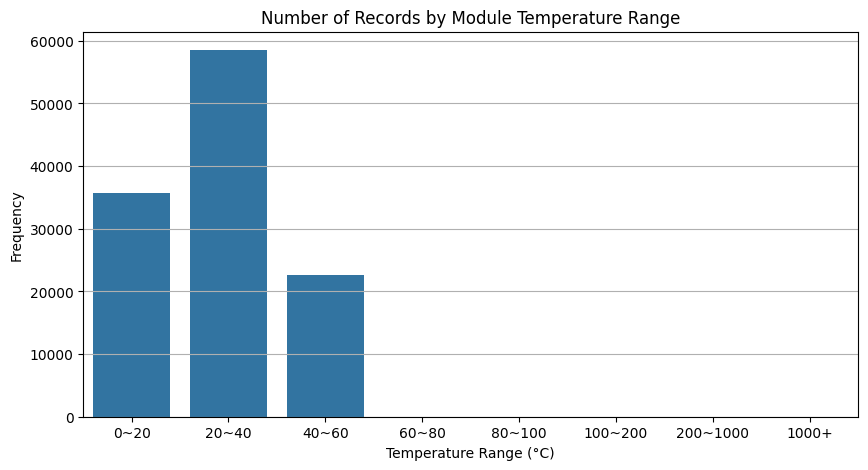

In [ ]:
bins = [0, 20, 40, 60, 80, 100, 200, 1000, 10000]
labels = ['0~20', '20~40', '40~60', '60~80', '80~100', '100~200', '200~1000', '1000+']
df['온도구간'] = pd.cut(df['모듈온도(°C)'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10, 5))
sns.countplot(x='온도구간', data=df, order=labels)
plt.title("Number of Records by Module Temperature Range")
plt.xlabel("Temperature Range (°C)")
plt.ylabel("Frequency")
plt.grid(True, axis='y')
plt.show()

60도 이상의 값들을 이전값으로 대체하는 보간법을 진행하였음.

In [ ]:
df.describe()

,Datatime,용량(MW),정격출력(kWh),모듈용량(Wp),모듈수량,경사면일사량,INV0001_발전량,INV0002_발전량,강수량(mm),외기온도(°C),모듈온도(°C)
count,117200,117200.000000,117200.000000,117200.000000,117200.000000,116595.000000,1.157830e+05,63030.000000,117200.000000,116595.000000,117200.000000
mean,2024-04-20 06:20:50.293515264,0.783287,610.761519,385.143046,2035.664172,388.496900,1.866780e+05,146872.097065,0.016717,57.945058,27.224098
min,2023-03-01 08:00:00,0.428220,500.000000,375.000000,1098.000000,0.000000,-7.232981e+06,-116962.000000,0.000000,-6.551667,-9.838333
25%,2023-09-12 13:00:00,0.659100,500.000000,375.000000,1690.000000,153.025595,6.598100e+04,43000.000000,0.000000,11.351667,16.976667
50%,2024-05-16 14:00:00,0.803250,500.000000,390.000000,2142.000000,357.416667,1.599500e+05,125986.000000,0.000000,19.828333,26.348333
75%,2024-11-27 08:00:00,0.938250,750.000000,390.000000,2466.000000,599.850000,2.829990e+05,238154.750000,0.000000,26.450000,37.245989
max,2025-04-30 16:00:00,0.999000,750.000000,390.000000,2664.000000,1871.350000,7.860000e+05,486039.000000,1.000000,6553.405000,59.971667
std,NaN,0.168888,124.186945,7.018884,445.302176,262.805069,1.430961e+05,116796.446216,0.096917,482.614551,13.932763


---

\
**3-1) 발전량 보정**\
describe를 통해 확인한 결과
1) 발전량의 값이 음수인 것\
2) 발전량의 값이 너무 과도하게 나오는 것\
위 두 가지가 문제가 된다고 생각함.


In [ ]:
# 음수인 발전량을 0으로 클리핑 하는 과정
df["INV0001_발전량"] = df["INV0001_발전량"].clip(lower=0)
df["INV0002_발전량"] = df["INV0002_발전량"].clip(lower=0)
df["발전량합계"] = df['INV0001_발전량'] + df['INV0002_발전량']

In [ ]:
df.describe()

,Datatime,용량(MW),정격출력(kWh),모듈용량(Wp),모듈수량,경사면일사량,INV0001_발전량,INV0002_발전량,발전량합계,강수량(mm),외기온도(°C),모듈온도(°C)
count,117200,117200.000000,117200.000000,117200.000000,117200.000000,116595.000000,115783.000000,63030.000000,62985.000000,117200.000000,116595.000000,117200.000000
mean,2024-04-20 06:20:50.293515264,0.783287,610.761519,385.143046,2035.664172,388.496900,186746.335827,146874.032143,308395.582678,0.016717,57.945058,27.224098
min,2023-03-01 08:00:00,0.428220,500.000000,375.000000,1098.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.551667,-9.838333
25%,2023-09-12 13:00:00,0.659100,500.000000,375.000000,1690.000000,153.025595,65981.000000,43000.000000,110162.000000,0.000000,11.351667,16.976667
50%,2024-05-16 14:00:00,0.803250,500.000000,390.000000,2142.000000,357.416667,159950.000000,125986.000000,271757.000000,0.000000,19.828333,26.348333
75%,2024-11-27 08:00:00,0.938250,750.000000,390.000000,2466.000000,599.850000,282999.000000,238154.750000,478689.000000,0.000000,26.450000,37.245989
max,2025-04-30 16:00:00,0.999000,750.000000,390.000000,2664.000000,1871.350000,786000.000000,486039.000000,955039.000000,1.000000,6553.405000,59.971667
std,NaN,0.168888,124.186945,7.018884,445.302176,262.805069,141409.192868,116793.081882,223389.413700,0.096917,482.614551,13.932763


In [ ]:
df.head(10)

,Datatime,발전소명,용량(MW),정격출력(kWh),모듈용량(Wp),모듈수량,경사면일사량,INV0001_발전량,INV0002_발전량,발전량합계,강수량(mm),외기온도(°C),모듈온도(°C),온도구간
2,2023-03-01 08:00:00,A,0.80325,500,375,2142,33.716667,10000.0,9374.0,19374.0,0.0,10.556667,11.043333,0~20
4,2023-03-01 10:00:00,A,0.80325,500,375,2142,65.300000,22749.0,24000.0,46749.0,0.0,10.556667,11.415000,0~20
5,2023-03-01 11:00:00,A,0.80325,500,375,2142,98.533333,35995.0,37691.0,73686.0,0.0,10.831667,12.541667,0~20
7,2023-03-01 13:00:00,A,0.80325,500,375,2142,189.833333,69759.0,74400.0,144159.0,0.0,11.695000,15.355000,0~20
8,2023-03-01 14:00:00,A,0.80325,500,375,2142,255.516667,90005.0,97308.0,187313.0,0.0,11.400000,16.935000,0~20
9,2023-03-01 15:00:00,A,0.80325,500,375,2142,359.033333,135509.0,142074.0,277583.0,0.1,10.535000,16.368333,0~20
10,2023-03-01 16:00:00,A,0.80325,500,375,2142,356.216667,125727.0,126909.0,252636.0,0.0,10.080000,16.136667,0~20
15,2023-03-02 08:00:00,A,0.80325,500,375,2142,308.166667,96001.0,106880.0,202881.0,0.0,4.115000,7.255000,0~20
16,2023-03-02 09:00:00,A,0.80325,500,375,2142,539.500000,196954.0,214250.0,411204.0,0.0,5.053333,12.063333,0~20
17,2023-03-02 10:00:00,A,0.80325,500,375,2142,720.750000,272952.0,286986.0,559938.0,0.0,6.203333,16.756667,0~20


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117200 entries, 2 to 176824
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Datatime     117200 non-null  datetime64[ns]
 1   발전소명         117200 non-null  object        
 2   용량(MW)       117200 non-null  float64       
 3   정격출력(kWh)    117200 non-null  int64         
 4   모듈용량(Wp)     117200 non-null  int64         
 5   모듈수량         117200 non-null  int64         
 6   경사면일사량       116595 non-null  float64       
 7   INV0001_발전량  115783 non-null  float64       
 8   INV0002_발전량  63030 non-null   float64       
 9   발전량합계        62985 non-null   float64       
 10  강수량(mm)      117200 non-null  float64       
 11  외기온도(°C)     116595 non-null  float64       
 12  모듈온도(°C)     117200 non-null  float64       
 13  온도구간         116792 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(8), int64(3), object(1)
memory usage: 12.6+ MB

# 4. PR 모델링
정상 패턴만 분류해야 하기 때문에 전체 고장 및 국소 고장인 부분에 대해서 전부 제외 시킨 후, PR 값을 계산하는 과정이 필요함.\
1) class 내부에서 쓸 데이터셋 설정\
2) 출력제어 시간에 해당되는 열 전부 삭제\
3) pr이 1이 넘는 곳이 거의 다 인버터가 2개인 발전소 인 것으로 보아 인버터가 2개인 발전소와 인버터가 1개인 발전소에 pr을 적용하는 공식이 다르게 적용되어야 할 것으로 보임.


In [ ]:
class PRModeling:
    # 초기 데이터셋 설정
    def __init__(self, dataset):
        self.dataset = dataset

    # 출력 제어 시간에 해당 하는 행을 삭제하는 함수
    def control_time_delete(self, df_control):

        records = []

        for _, row in df_control.iterrows():
            date_str = pd.to_datetime(row["출력제한일"]).strftime("%Y-%m-%d")
            start_str, end_str = row["정지시간(통보문자)"].split("~")
            sh, sm = map(int, start_str.split(":"))
            eh, em = map(int, end_str.split(":"))
            hours = range(sh, eh + (1 if em > 0 else 0))

            for h in hours:
                dt = pd.to_datetime(f"{date_str} {h:02d}:00:00")
                records.append({"발전소명": row["발전소명"], "Datatime": dt})

            # 리스트를 DataFrame으로 변환
            ctrl_df = pd.DataFrame.from_records(records)

            # 2) anti-join: self.dataset 에 ctrl_df를 left merge 후, '_merge'=='left_only'인 행만 남기기
            merged = self.dataset.merge(
                ctrl_df,
                on=["발전소명", "Datatime"],
                how="left",
                indicator=True            # 매치 여부를 '_merge' 컬럼에 기록
            )

            # '_merge'가 'left_only'인(=ctrl_df와 매칭되지 않은) 행만 남김 → 제어 구간 제거 완료
            self.dataset = (
                merged[merged["_merge"] == "left_only"].drop(columns=["_merge"])
            )

    # 고장 내역에 해당 되는 시간들 제외
    def fault_time_delete(self, fault_periods):

        df = self.dataset.copy()
        mask_all = pd.Series(False, index=df.index)

        for fp in fault_periods:
            start = pd.to_datetime(fp['start'], format='%Y-%m-%d-%H', errors='coerce')
            end = pd.to_datetime(fp['end'], format='%Y-%m-%d-%H', errors='coerce')
            mask = (
                (df['발전소명'] == fp['plant']) &
                (df['Datatime'] >= start) &
                (df['Datatime'] <= end)
            )
            mask_all |= mask
        self.dataset = df.loc[~mask_all]

    # 이상치랑 별개로 PR 모델링에는 정상 데이터만 사용해야 하므로 국소, 전체 고장 행 전부 제외
    def pr_preprocess(self):
        df = self.dataset.copy() #self.dataset으로 표기하기에는 번거로울 것 같아서 치환하여 사용하고 다시 변경 예정

        # 발전량이 0이거나 "-" 인 값들은 제외
        df = df[~((df["INV0001_발전량"] == 0) & (df["INV0002_발전량"] == 0))]
        df = df[~((df["INV0001_발전량"] == 0) & (df["INV0002_발전량"] == "-"))]
        df = df[~((df["INV0001_발전량"] == "-") & (df["INV0002_발전량"] == "-"))]

        # 발전량이 다 공백인 경우도 제외
        df = df[~((df["INV0001_발전량"].isna() | (df["INV0001_발전량"].astype(str).str.strip() == "")) &
                (df["INV0002_발전량"].isna() | (df["INV0002_발전량"].astype(str).str.strip() == "")))]
        df = df[~((df["INV0001_발전량"] == 0) & (df["INV0002_발전량"].isna() | (df["INV0002_발전량"].astype(str).str.strip() == "")))]

        # 경사면 일사량이 20 이하인 것들은 제외 시키기
        df["경사면일사량"] = pd.to_numeric(df["경사면일사량"], errors='coerce')
        df = df[~(df["경사면일사량"] <= 100)]    # 100이라는 cutoff 수정될 가능성 있음.
        df = df[~(df["경사면일사량"] >= 1000)] # 1000이라는 값도 수정될 가능성 있음.
        df = df[~(df["경사면일사량"] == "-")] # 경사면 일사량 값이 "-"인 것들 전부 제외하기

        # 외기온도(°C), 모듈온도(°C) 값이 100 이상인 것들은 제외
        df = df[(df["외기온도(°C)"] <= 100)]   # 150이라는 cutoff 수정될 가능성 있음.
        df = df[(df["모듈온도(°C)"] <= 100)]

        # 발전량이 음수인 값들 제외하기
        df = df[~(df["INV0001_발전량"] <= 0)]
        df = df[~(df["INV0002_발전량"] <= 0)]

        # 외기온도랑 모듈온도 값이 비어있는 것들 전부 제외
        df = df[~((df["모듈온도(°C)"].isna() | (df["모듈온도(°C)"].astype(str).str.strip() == "")) &
                (df["외기온도(°C)"].isna() | (df["외기온도(°C)"].astype(str).str.strip() == "")))]

        # 또 추가할만한 전처리 조건 있으면 추가하기

        self.dataset = df #치환하여 전처리 하였고 다시 변경

    # 정상 PR 모델링에 필요한 열만 선택함.
    def select_columns(self, columns):
        self.dataset = self.dataset[columns]

    def calculate_pr(self):
        df = self.dataset.copy()

        # 1) PR 계산에 사용할 컬럼들 숫자형으로 변환
        to_num = ["발전량합계", "경사면일사량", "정격출력(kWh)", "모듈온도(°C)"]
        df[to_num] = df[to_num].apply(pd.to_numeric, errors="coerce")

        # 2) Temperature coefficient 보정 계수
        #    re_coefficient = 1 + α * (T_module - 25)
        #    여기선 α = -0.0039
        df["re_coefficient"] = 1 + (-0.0039) * (df["모듈온도(°C)"] - 25)

        # 3) 유효 일사량 (corrected irradiance)
        df["effective_irradiance"] = df["경사면일사량"]  * df["re_coefficient"]

        # 4) 기준 에너지량 (reference energy)
        #    단위 맞추기 위해 1000으로 나눔 (W·h → kWh)
        df["reference_energy"] = (df["effective_irradiance"] / 1000) * (df["용량(MW)"] * 1000)

        # 5) 0 또는 NaN 으로 나누는 경우 방지
        df["reference_energy"] = df["reference_energy"].replace({0: np.nan})

        # 6) PR 계산
        self.dataset["PR"] = (df["발전량합계"] / 1000) / df["reference_energy"]

        return self.dataset

    # 결과를 반환하는 함수
    def get_result(self):
        return self.dataset


In [ ]:
### 3. PR 모델링

#PR 모델링을 위한 코드
model = PRModeling(df)
model.control_time_delete(df_control)  # 출력 제어 시간에 해당하는 행 삭제

# 고장 내역 수기로 직접 입력하기
fault_periods = [{'plant': "D" ,'start': "2024-06-27-06",'end': "2024-07-01-18"}, {'plant': "I" ,'start': "2024-10-15-06",'end': "2024-10-16-18"},
                 {'plant': "S" ,'start': "2024-10-18-06",'end': "2024-10-18-18"}, {'plant': "D" ,'start': "2024-10-18-06",'end': "2024-10-18-18"},
                 {'plant': "N" ,'start': "2024-10-22-06",'end': "2024-10-22-18"}, {'plant': "I" ,'start': "2024-10-21-06",'end': "2024-10-23-18"},
                 {'plant': "D" ,'start': "2025-02-12-06",'end': "2025-02-25-18"}, {'plant': "E" ,'start': "2025-03-26-06",'end': "2025-03-28-18"},
                 {'plant': "D" ,'start': "2024-08-03-06",'end': "2024-08-29-18"}, {'plant': "I" ,'start': "2025-03-30-06",'end': "2025-03-31-18"},
                 {'plant': "E" ,'start': "2025-03-26-06",'end': "2025-03-28-18"},]

model.fault_time_delete(fault_periods)
model.pr_preprocess()  # PR 모델링을 위한 전처리, cutoff는 경사면 일사량 제외 기준

pr_columns = ["Datatime", "발전소명", "용량(MW)",  "정격출력(kWh)", "경사면일사량",
              "INV0001_발전량", "INV0002_발전량", "발전량합계", "강수량(mm)", "외기온도(°C)", "모듈온도(°C)",  ] # PR 모델링에 필요한 열들만 넣으면 됨. 아직 다 넣지 않음.
model.select_columns(pr_columns)

model.calculate_pr()  # PR 값 계산

df_pr = model.get_result()

df_pr = df_pr[["Datatime", "발전소명", "경사면일사량", "INV0001_발전량", "INV0002_발전량", "발전량합계", "강수량(mm)", "외기온도(°C)", "모듈온도(°C)", "PR"]]

In [ ]:
df_pr.describe()

,Datatime,경사면일사량,INV0001_발전량,INV0002_발전량,발전량합계,강수량(mm),외기온도(°C),모듈온도(°C),PR
count,90564,90564.000000,90525.000000,47941.000000,47902.000000,90564.000000,90564.000000,90564.000000,47902.000000
mean,2024-03-29 20:34:48.034980864,447.573005,216980.498117,186127.964248,371222.250344,0.009897,20.050187,29.349421,0.917392
min,2023-03-01 11:00:00,100.016667,38.000000,38.000000,76.000000,0.000000,-6.551667,-8.410169,0.000143
25%,2023-08-26 15:00:00,244.518590,107000.000000,94368.000000,189864.500000,0.000000,12.947542,20.869583,0.883088
50%,2024-05-03 11:00:00,420.675000,195044.000000,172737.000000,344803.500000,0.000000,21.158333,29.398319,0.947999
75%,2024-10-21 11:00:00,631.358616,304272.000000,268884.000000,532826.750000,0.000000,27.481500,38.813333,1.005817
max,2025-04-30 16:00:00,999.733333,716095.000000,474982.000000,944523.000000,1.000000,86.623333,59.971667,2.587832
std,NaN,232.014277,131867.315404,104566.868997,208030.799967,0.072898,9.172196,13.027902,0.188792


# 5. 구한 PR 값을 토대로 정상 데이터 학습 시키기

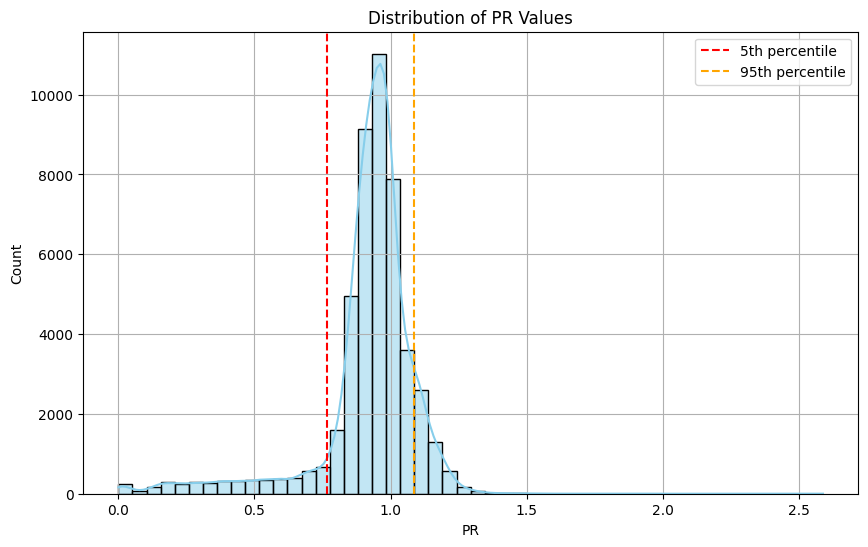

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_pr['PR'], bins=50, kde=True, color='skyblue')

# 분위수 기준선 추가
plt.axvline(df_pr['PR'].quantile(0.10), color='red', linestyle='--', label='5th percentile')
plt.axvline(df_pr['PR'].quantile(0.90), color='orange', linestyle='--', label='95th percentile')

plt.title("Distribution of PR Values")
plt.xlabel("PR")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

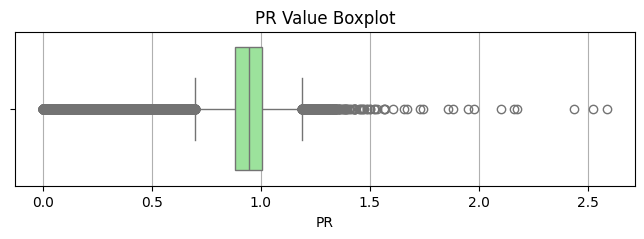

In [ ]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=df_pr['PR'], color='lightgreen')
plt.title("PR Value Boxplot")
plt.xlabel("PR")
plt.grid(True, axis='x')
plt.show()